In [1]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas
from matplotlib import pyplot as plt
import os.path
import matplotlib as mpl
from typing import *


MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000*1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

BENCHS = {
    'lusearch': 'lusearch.3023.70',
    'cassandra': 'cassandra.3023.269',
    'h2': 'h2.3023.3489',
    'tomcat': 'tomcat.3023.76',
}

log = lambda runid, buildstring: f'/home/wenyuz/MMTk-Dev/evaluation/results/log/{runid}/{buildstring}'

# Phase time curve

In [6]:
MIN_PAUSE_USEC = 1
MAX_PAUSE_USEC = 1000*1000 # 1 sec
PAUSE_SIGNIFICANT_DIGITS = 5

def load_phase_time_data(invocation, folder):
    path = "{}.{}/pauses.csv".format(folder, invocation)
    if not os.path.isfile(path):
        return None
    names = ['total', 'wait', 'stack', 'init', 'zero', 'prepare', 'closure', 'refclosure', 'refforwarding', 'release', 'copy', 'incs', 'kind']
    df = pandas.read_csv(path, skiprows=1, names=names)
    print(df.describe())
    for name in names:
        df[name] = df[name] / 1000
    return df

def plot_phase_data(bench, title, phase, data: Dict[str, Union[str, List[str]]], invocations = 10, save = None, ax = None, labelSize = 26, tickSize = 20):
    # print('Loading...')
    folders_dict = data
    gcs = list(folders_dict.keys())
    histograms = {}
    for gc in gcs:
        histograms[gc] = []
        for i in range(invocations):
            folders = folders_dict[gc] if isinstance(folders_dict[gc], list) else [folders_dict[gc]]
            for folder in folders:
                histogram = HdrHistogram(MIN_PAUSE_USEC, MAX_PAUSE_USEC, PAUSE_SIGNIFICANT_DIGITS)
                data = load_phase_time_data(i, folder)
                if data is None:
                    continue
                latencies = data[phase]
                for l in latencies:
                    histogram.record_value(l)
                histograms[gc].append(histogram)
    
    # print('Processing...')
    percentile_list = []
    for gc, hists in histograms.items():
        for j, histogram in enumerate(hists):
            for i in histogram.get_percentile_iterator(5):
                x = i.percentile_level_iterated_to
                percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
    percentile_df = pandas.DataFrame(percentile_list)
    percentile_df["other"] = 1 / (1 - percentile_df["percentile"])

    # print('Plotting...')
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(16,12))
        # fig.suptitle(title, fontsize=26)
    ax.title.set_text(title)
    sns.color_palette()
    colors = ['green', 'blue', 'orange', 'red'][:len(gcs)]
    # print(f'{gcs} {colors}')
    sns.lineplot(data=percentile_df, x="other", y="value", hue="GC", palette=colors, ax=ax)
    # sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
    ax.set_xscale('log')
    ax.set_xlabel('', fontsize=labelSize, labelpad=12)
    ax.set_ylabel('Time (msec)', fontsize=labelSize, labelpad=12)
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(['0', '90', '99', '99.9', '99.99', '99.999', '99.9999'], fontsize=tickSize)
    plt.yticks(fontsize=tickSize)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{x / 1000:.3f}'.format(x)))
    # plt.legend(fontsize=16)

    if save is not None:
        plt.savefig(save, bbox_inches='tight')


def plot_phases(bench, data: Union[str, List[str]], invocations=20):
    fig, ax = plt.subplots(2, 3, figsize=(20,10))
    def _plot_phase(ax, phase, title):
        plot_phase_data(
            bench = bench,
            phase = phase,
            title = title,
            data = { 'LXR': data },
            invocations = invocations,
            ax = ax,
            labelSize=None,
            tickSize=None
        )
    _plot_phase(ax[0, 0], 'total', 'Total')
    _plot_phase(ax[0, 1], 'wait', 'Wait for lazy decs / sweep, mature collection set selection')
    _plot_phase(ax[0, 2], 'stack', 'Stack scanning')
    _plot_phase(ax[1, 0], 'init', 'Incs')
    _plot_phase(ax[1, 1], 'zero', 'Zeroing')
    # _plot_phase(ax[1, 1], 'prepare', '#4 Prepare')
    _plot_phase(ax[1, 2], 'closure', 'Mature evac, STW marking, SATB ModBuf')
    # _plot_phase(ax[1, 2], 'release', '#7 Release')

## lusearch

              total          wait          stack          init           zero  \
count  9.990000e+02  9.990000e+02     999.000000  9.990000e+02     999.000000   
mean   2.642695e+06  1.573710e+06  203491.595596  3.521832e+05   24460.035035   
std    1.656802e+06  1.141754e+05   19051.935250  1.503470e+06   48632.260839   
min    1.828038e+06  9.913890e+05  145974.000000  1.562830e+05     140.000000   
25%    2.313008e+06  1.516003e+06  191063.500000  2.313090e+05     190.000000   
50%    2.396785e+06  1.588449e+06  201889.000000  2.571020e+05     201.000000   
75%    2.536346e+06  1.648056e+06  214061.000000  2.838225e+05     251.000000   
max    4.462201e+07  1.907818e+06  296115.000000  4.190228e+07  174076.000000   

            prepare       closure  refclosure  refforwarding        release  \
count    999.000000  9.990000e+02  999.000000     999.000000     999.000000   
mean    8501.695696  2.890026e+05  177.877878     172.877878  168463.705706   
std     4371.414283  5.858289e+05

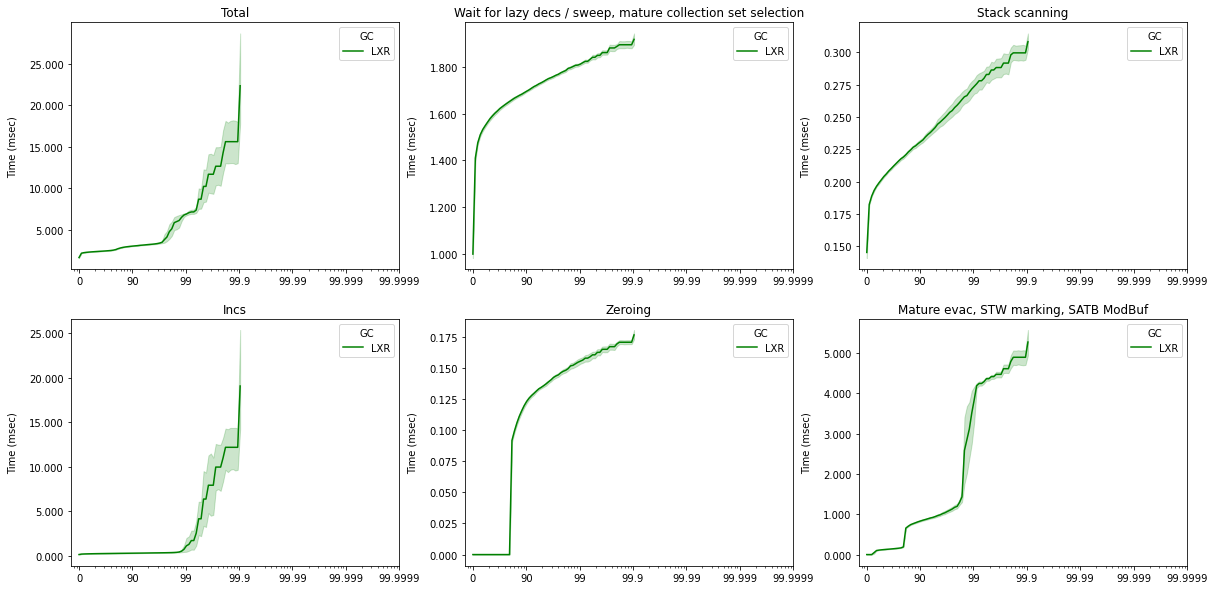

In [3]:
BENCH = 'lusearch'

runid1 = 'elk-2021-12-10-Fri-203402'

plot_phases(BENCH, log(runid1, f'{BENCHS[BENCH]}.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'))

## cassandra

              total          wait          stack          init           zero  \
count  9.600000e+01  9.600000e+01      96.000000  9.600000e+01      96.000000   
mean   1.043986e+07  5.615138e+06  359061.041667  3.078745e+06   92938.270833   
std    1.598874e+06  1.011038e+05   53212.819514  1.041455e+06   94342.805585   
min    7.306547e+06  5.403781e+06  229209.000000  6.294500e+05     110.000000   
25%    9.426741e+06  5.553277e+06  326517.000000  2.328282e+06     200.000000   
50%    1.031336e+07  5.599198e+06  350312.000000  3.438662e+06   73588.000000   
75%    1.137542e+07  5.680779e+06  378281.750000  3.805564e+06  184000.000000   
max    1.480857e+07  5.899080e+06  540053.000000  5.124798e+06  231343.000000   

            prepare       closure  refclosure  refforwarding        release  \
count     96.000000  9.600000e+01   96.000000      96.000000      96.000000   
mean   27153.385417  1.044925e+06  184.916667     167.770833  181531.072917   
std     3592.722707  1.168037e+06

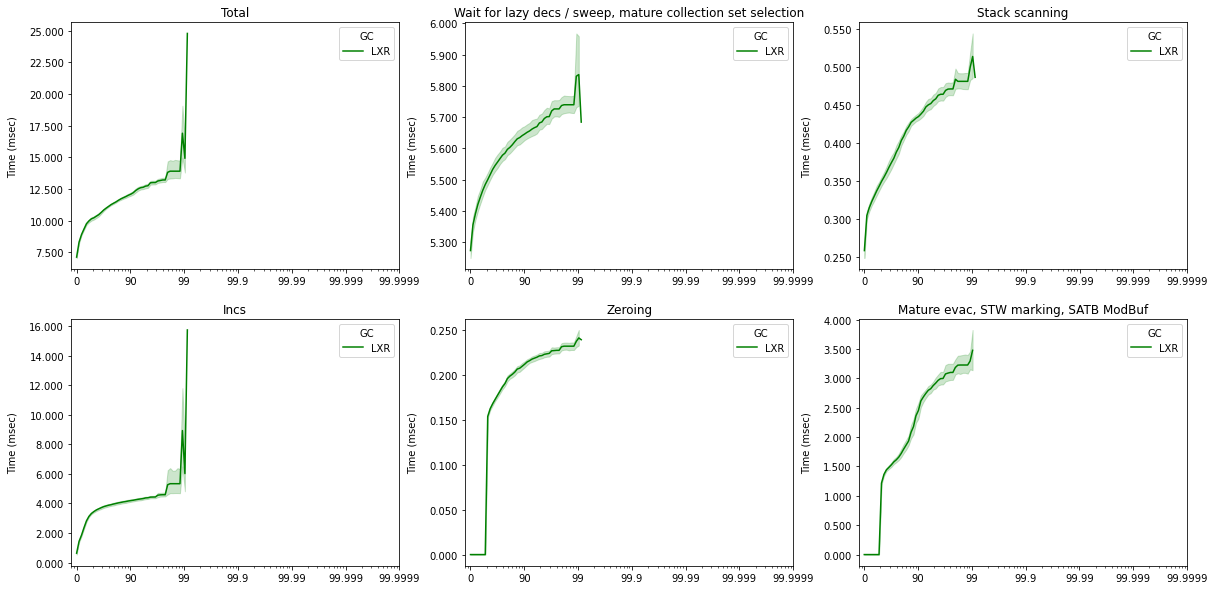

In [4]:
BENCH = 'cassandra'

runid1 = 'elk-2021-12-10-Fri-203402'

plot_phases(BENCH, log(runid1, f'{BENCHS[BENCH]}.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'))

## h2

KeyError: 'percentile'

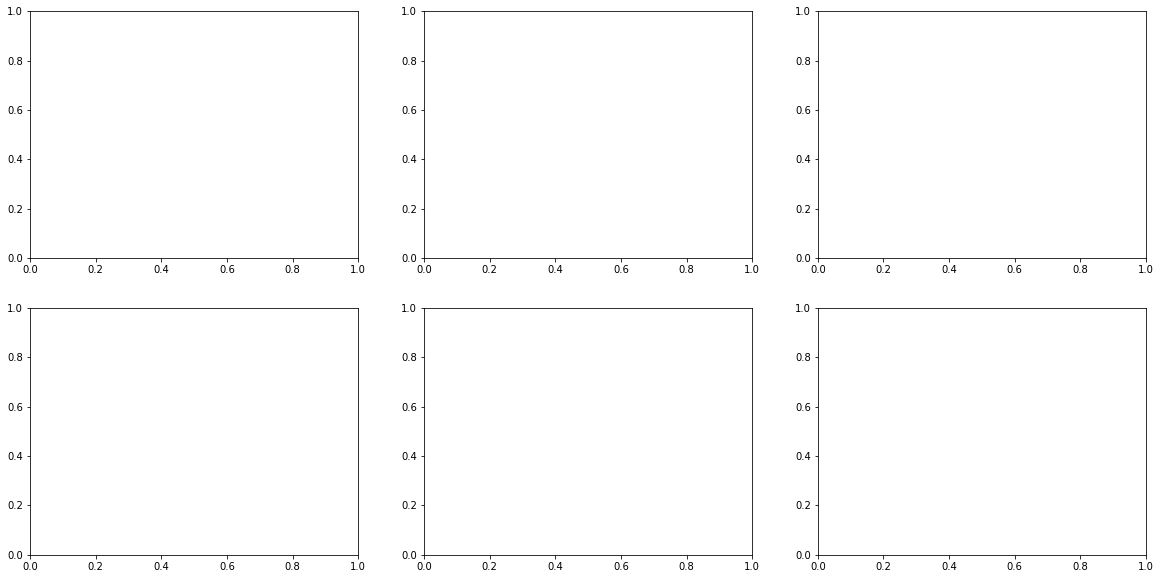

In [9]:
BENCH = 'h2'

runid1 = 'elk-2021-12-10-Fri-203402'

for i in range(20):
    plot_phases(BENCH, log(runid1, f'{BENCHS[BENCH]}.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'), invocations=1)

## tomcat

              total          wait          stack          init           zero  \
count  5.260000e+02  5.260000e+02     526.000000  5.260000e+02     526.000000   
mean   6.822945e+06  5.420943e+06  247219.777567  6.587420e+05   33704.950570   
std    1.321702e+06  1.359042e+05   34211.516367  1.233433e+06   56782.909216   
min    6.066332e+06  4.977099e+06  172153.000000  3.480930e+05     140.000000   
25%    6.419919e+06  5.320712e+06  223483.750000  4.584848e+05     191.000000   
50%    6.583966e+06  5.441996e+06  239845.000000  4.869775e+05     210.500000   
75%    6.912332e+06  5.522279e+06  262246.750000  5.175150e+05   93971.500000   
max    2.221174e+07  5.706065e+06  466634.000000  1.559528e+07  188222.000000   

            prepare       closure  refclosure  refforwarding        release  \
count    526.000000  5.260000e+02  526.000000     526.000000     526.000000   
mean    9894.401141  2.713645e+05  177.190114     177.587452  156463.813688   
std     4507.137999  3.267569e+05

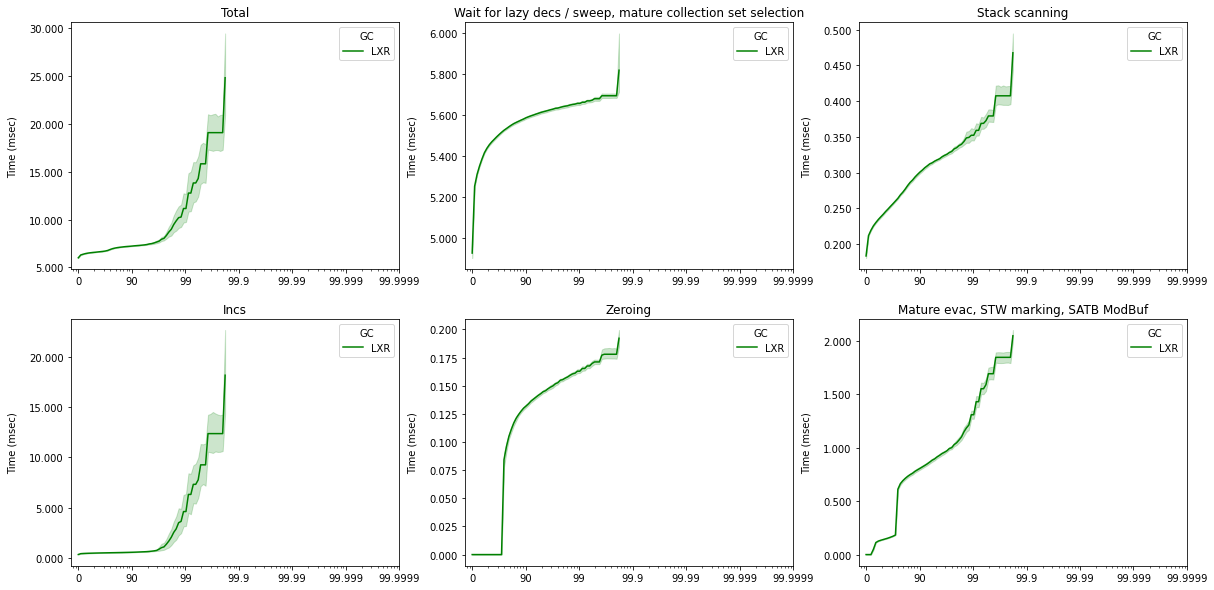

In [6]:
BENCH = 'tomcat'

runid1 = 'elk-2021-12-10-Fri-203402'

plot_phases(BENCH, log(runid1, f'{BENCHS[BENCH]}.jdk.ix.common.tph.mmtk_perf.nr-1.dacapochopin-29a657f'))